In [1]:
from aixi_booster import *
import numpy as np
import pandas as pd
import random

In [2]:
#X = np.array(np.arange(1000),ndmin=2).T
#Y = np.array(np.sin(X/12.),ndmin=2)

In [3]:
np.random.seed(0)
random.seed(0)

In [4]:
#делаем датасет
#Суть датасета: есть зашумлённая синусоида, на которую наложены случайные блуждания. 
#AIXI примерно знает текущее состояние блужданий и немного устаревшие значения этой "синусоиды"
j = 0
X_lst = []
Y_lst = []
X_rec = [0, 0]
k = 0
dk = -0.02
for i in range(5500):
    j += (np.random.rand()-0.5)*6
    dk += (np.random.rand()-0.48)*0.001
    k += dk
    Y_rec = [np.sin(X_rec[0]*0.02 + X_rec[1]*0.0000001) * (1 + np.cos(X_rec[0] * 0.001) * X_rec[1] * 0.1) + k]
    Y_prev = 0
    if len(Y_lst)>5:
        Y_prev = Y_lst[-5][0]
    X_rec = [i, j, dk, Y_prev]
    X_lst.append(X_rec)
    Y_lst.append(Y_rec)
X = np.array(X_lst)
Y = np.array(Y_lst)

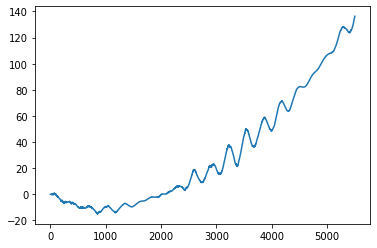

In [5]:
plt.plot(Y)

In [ ]:
%%time
#forest_count - число гипотез, то есть размер леса гипотез
#episodes - эпизоды работы AIXI. Если в реальной жизни данные - это несколько блоков по несколько записей.
#Причём каждый блок - это последовательность, у которой известно прошлое, но неизвестно будущее и неизвестны другие последовательности.
#Вот эпизоды - это такие последовательности. Например, если у нас данные - это 2 поездки на машине в 10 минут и в 50 минут, то первым эпизодом будут данные из одной поездки, а вторым - из второй.
#sample_part - сколько последовательностей использовать для генерации каждой одной гипотезы
#popsize, maxiter, alpha_count, elitarism, mutation_p - параметры эволюции (мы не будет тупо перебирать гипотезы)
#popsize - размер популяции, maxiter - число поколений, alpha_count - число альфачей (кто размножается), elitarism - число элитариев (кто сохраняется в неизменном виде в следующем поколении) 
#mutation_p - вероятность мутации
#boosting_count - каждая гипотеза сделана по схеме "бустинг". То есть вначале подбираем гипотезу, 
#которая максимально хорошо предсказывает Y, затем гипотезу, которая максимально хорошо исправляет ошибки первой гипотезы и так далее
#boosting_count - это число слоёв в этом "бутерброде"
model = symbolic_regression_multyboosting(size_genom=900, tact_count=30, regularization=1.,postprocessing_prod='lin', postprocessing_learn='lin')
fractor = 22
episodes = []
for i in range(fractor):
    episodes.append([i*int(len(Y)/fractor), (i+1)*int(len(Y)/fractor)])
episodes_train = episodes[:-5]
episodes_test = episodes[-5:]
border = episodes_train[-1][-1]
X_train = X[:border]
Y_train = Y[:border]
X_test = X[border:]
Y_test = Y[border:]
model.fit(X_train,Y_train,forest_count=20,sample_part=0.8,episodes=episodes_train,popsize=30, maxiter=3, boosting_count=2, alpha_count=5, elitarism=2, mutation_p=0.02, n_jobs=7)

FOREST NUMBER 0, episodes [[2000 2250]
 [3750 4000]
 [3250 3500]
 [2000 2250]
 [2750 3000]
 [2750 3000]
 [2000 2250]
 [1750 2000]
 [ 500  750]
 [2750 3000]
 [3750 4000]
 [1250 1500]
 [1750 2000]
 [ 750 1000]]
p_arr max,min,med,q0.25,q0.75 0.6666666666666666 0.0037907505686884005 0.032864782276615226 0.021130511062259077 0.06130115089538842


In [7]:
#Архитектура ML-модели:
#symbolic_regression_multyboosting, он же FOREST - массив под-моделей symbolic_regression_boosting. Соединены как random forest, параллельно
#symbolic_regression_boosting - массив моделей symbolic_regression, соединённых как бустинг, последовательно
#symbolic_regression - машина Тьюринга и пост-обработчик в виде какой-нибудь модели ML. Модель выбирается автоматом из Ridge, Xgboost и стекинга Xgboost+Ridge

In [8]:
Y_pred = model.predict(X_test,return_hist=True)
#ПРОТОКОЛ ГИСТОГРАММЫ: [pred_list,p_array,m_pred]  
#pred list - это прогноз ы отдельных моделей
#p_array - это вероятности этих моделей быть истинными (очень условно, но это терминология AIXI. Вероятность зависит от mse и числа ненулевых генов)
#m_pred - матожидание результата. Взвешенная сумма всех прогнозов

ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
#train
#отрисовать факт синим
#Y_pred = model.predict(X_train,return_hist=True)
for episod in episodes_train:
    #мы учили систему выдавать последовательности длиной в 500/4, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y[episod[0]:episod[1],:])
    Y_pred = model.predict(X_train[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    print('Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности')
    print('Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны')
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ), label=f'p={np.round(p_array[i], 6) * 100}%' )
    plt.legend()
    plt.show()

In [ ]:
#test
#отрисовать факт синим
#Y_pred = model.predict(X_train,return_hist=True)
for episod in episodes_test:
    #мы учили систему выдавать последовательности длиной в 500/3, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y[episod[0]:episod[1],:])
    Y_pred = model.predict(X[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    print('Отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности')
    print('Прогноз итеративный, но синюю линию агент вообще не видит, это Y, а агент видит переменные X, они не показаны')
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ), label=f'p={np.round(p_array[i], 6) * 100}%' )
    plt.legend()
    plt.show()

In [ ]:
#Нарисовать прогноз всего ряда ЦЕЛИКОМ
for episod in episodes:
    #мы учили систему выдавать последовательности длиной в 500/4, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(np.arange(episod[0],episod[1]),Y[episod[0]:episod[1],:])
    Y_pred = model.predict(X[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    for i in range(len(pred)):
        if 15+np.log(p_array[i])>0:
            plt.plot(np.arange(episod[0],episod[1]),pred[i],'--',linewidth=0.1*np.max([15+np.log(p_array[i]),0] ))
    #plt.legend()
    #plt.show()
    

plt.legend()
plt.show()

In [ ]:
episodes

In [ ]:
1/0

In [ ]:
#делаем датасет
#Суть датасета: есть рандомные массивы, надо найти максимум
X_lst = []
Y_lst = []
for i in range(1000):
    X_rec = np.random.rand(6)*20
    Y_rec = [np.max(X_rec)]
    X_lst.append(X_rec)
    Y_lst.append(Y_rec)
X = np.array(X_lst)
Y = np.array(Y_lst,ndmin=2)

In [ ]:
plt.plot(Y)

In [ ]:
border = 500
X_train = X[:border,:]
X_test = X[border:,:]
Y_train = Y[:border,:]
Y_test = Y[border:,:]

In [ ]:
%%time
model = symbolic_regression_multyboosting(size_genom=900,tact_count=50, regularization=1.)
episodes=[]
for i in range(len(Y_train)-1):
    episodes.append([i,i+1])
model = symbolic_regression_multyboosting(size_genom=900,tact_count=30, regularization=1.)
model.fit(X_train,Y_train,forest_count=9,sample_part=0.8,episodes=episodes,popsize=30, maxiter=3, boosting_count=2, alpha_count=5, elitarism=2, mutation_p=0.02)

In [ ]:
#train
#отрисовать факт синим
for episod in episodes[:20]:
    #мы учили систему выдавать последовательности длиной в 1, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    plt.plot(Y_train[episod[0]:episod[1],:])
    Y_pred = model.predict(X_train[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    for i in range(len(pred)):
        #отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
        if 10+np.log(p_array[i])>0:
            plt.plot(pred[i],'--',linewidth=0.1*np.max([10+np.log(p_array[i]),0] ) )
    plt.show()

In [ ]:
#test
#отрисовать факт
counter = 0
lst = []
for episod in episodes:
    counter += 1
    #мы учили систему выдавать последовательности длиной в 1, на более длинных система работать не обязана, 
    #так что тестим на последовательностях той же длины
    draw = counter<10
    if draw:
        plt.plot(Y_test[episod[0]:episod[1],:])
    Y_pred = model.predict(X_test[episod[0]:episod[1],:],return_hist=True)
    [pred,p_array,m_pred] = Y_pred
    if draw:
        for i in range(len(pred)):
            #отрисовать прогноз - несколькими цветами, пунктиром, яркость пропорциональна вероятности
            if 10+np.log(p_array[i])>0:
                plt.plot(pred[i],'--',linewidth=0.1*np.max([10+np.log(p_array[i]),0] ) )
    mae = np.mean(np.abs(m_pred - Y_test[episod[0]:episod[1],:]))
    mae_mean = mae/np.mean(np.abs(Y_test[episod[0]:episod[1],:]))
    lst.append({'mae':mae, 'mae_mean':mae_mean})
    if draw:
        print('mae',mae,'mae_mean',mae_mean)
        plt.show()

In [ ]:
report = pd.DataFrame(lst)
report

In [ ]:
print(report.mae.mean(),report.mae_mean.mean())